In [1]:
%matplotlib inline
import re
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from timeit import Timer
from pww import PWW

# Detecting Remote Shells in a System Call Stream

## Parsing the Data

System call traces come in the following format:

```
system-call [argument ...] [=> return-value]
```

Every line is the system call name, followed by optional arguments, followed by optional return value preceded by `=>`. Each argument is a name-value pair, with the name separated from the value by `=`.  The parser is implemented by class `Syscall` in module `pww.syscall`.

In [2]:
from pww.syscall import Syscall

We can read the background trace now:

In [3]:
with open('../data/syscalls.txt') as inp:
    background = [Syscall(l) for l in inp]

## Remote Shell Pattern

Since we want to overlay the background trace with remote shell code, we define a generative model for the code. The code follows the following pattern:

```
accept fd=x => y
dup fd=y => 0 | dup fd=y => 1 | dup fd=y => 2
execve exe=z
```

See the paper for explanation of the pattern syntax.


In [4]:
from pww.syscall import gen_shell_code

Let's take a look at a generated shell code:

In [5]:
gen_shell_code()

['accept fd=127 => 128',
 'dup fd=128 => 1',
 'dup fd=128 => 2',
 'dup fd=128 => 0',
 'execve sh=csh']

In addition, we are going to search for the pattern in a stream window. While algorithm which matches any pattern in a window can be used, this is not a subject of our evaluation, and we hard-code the search.

In [6]:
from pww.syscall import search_shell_code

For evaluation purposes, we want to make sure that pattern instances do not appear sporadically (which is a reasonable real-life scenario but will mess with estimation of parameters). Let us check that there is no shell code in the background trace:

In [7]:
assert not search_shell_code(background)

## Progressive Window Widening
Here we use a simplified model in which one system call arrives per time unit.  We set the maximum subsequence length to 100 _system calls_, as explained in the paper.

In [8]:
T = len(background)   # total time
L_max = 100           # maximum subsequence length

## Amount of Work

In PWW, we decrease detection delay at the cost of increasing the amount of work.

### Bounds
Even before we use Progressive Window Widening, we can compute an _upper bound_ on the total amount of work $B_{PWW}= \rho T$ (see equation (2) in the paper). We will use actual execution time for this estimate, so the result will vary between different computers. In addition, $R_{fixed}$ is the amount of work while running a window of width $2L_{max}$ with step $L_{max}$ through the stream.

In [9]:
def fixed_work():
    for i in range(0, len(background) - 2*L_max, 2*L_max):
        search_shell_code(background[i:i+4*L_max])       
number_of_windows = len(background)/(2*L_max) - 1
N = 10
R_fixed = Timer(fixed_work, 'gc.enable()').timeit(number=N)/float(N)
def B_PWW(t): return 2* R_fixed * T / float(t * number_of_windows)

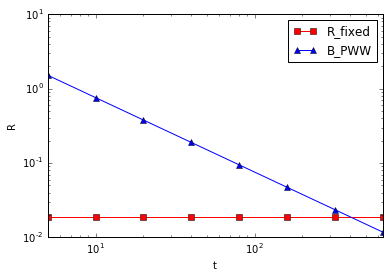

In [10]:
ts = [5, 10, 20, 40, 80, 160, 320, 640]
plt.plot(ts, [R_fixed for t in ts], 'r-s', ts, [B_PWW(t) for t in ts], 'b-^')
plt.xscale('log'); plt.yscale('log'); plt.xlim([min(ts), max(ts)])
plt.xlabel('t'); plt.ylabel('R'); plt.legend(labels=['R_fixed', 'B_PWW'])

When $t$ exceeds $4L_{\max}$, $B_{PWW}$ becomes smaller than $R_{fixed}$.

### Amount of work of PWW
We expect the amount of work $R_{PWW}$ of PWW to fall between $R_{fixed}$ and $B_{PWW}$:

In [11]:
def pww_work(t):
    PWW(search_shell_code, background, t, L_max)
def R_PWW(t): return Timer(lambda: pww_work(t), 'gc.enable()').timeit(number=N)/float(N)

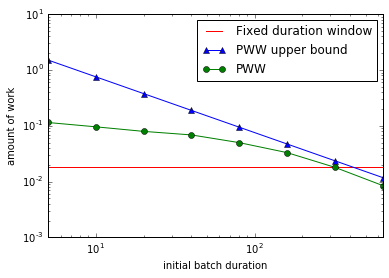

In [18]:
plt.plot(ts, [R_fixed for t in ts], 'r-',
         ts, [B_PWW(t) for t in ts], 'b-^',
         ts, [R_PWW(t) for t in ts], 'g-o')
plt.xscale('log'); plt.yscale('log'); plt.xlim([min(ts), max(ts)])
plt.xlabel('initial batch duration'); plt.ylabel('amount of work')
plt.legend(labels=['Fixed duration window', 'PWW upper bound', 'PWW'])
plt.savefig('syscalls-amount-of-work.pdf')

Indeed, the green line for $R_{PWW}$ lies (except for maybe rounding errors) between $R_{fixed}$ (red) and  $B_{PWW}$ (blue) for initial batch duration $t$ below 400, approximately. The longer will be the total stream, the closer will be $R_{PWW}$ and $B_{PWW}$ lines for the same values of $t$ because a higher percentage of windows will contain $4L_{max}$ elements.

## Detecton Delay
We use PWW to detect pattern occurences with shorter duration faster, at the cost of amount of work. Let us show that indeed the detection delay increases with pattern duration. We inject the shell code into the background, then search for the shell code and compare the shell code duration with the difference between the position at which the shellcode was detected and the first position at which it _could_ have been detected --- the difference is the _delay_.

In [13]:
from pww.syscall import inject_shell_code

Since in our simplified model one system call arrives per time unit, we set initial batch duration to the length of the shell code.

In [14]:
t = len(gen_shell_code())
ds = range(t, L_max, t)

The shell code is injected randomly given duration, and the detection delay is also random. We sample and average several injections and detections to estimate expected detection delay.

In [15]:
def delay(d):
    """Samples detection delay"""
    stream, pos = inject_shell_code(background, d)
    at = PWW(lambda window: search_shell_code(window, pause=0.), stream, t, L_max)
    delay = at - pos
    return delay

def average_delay(d, N=200):
    """Samples average detection delay"""
    return sum(delay(d) for _ in range(N))/float(N)

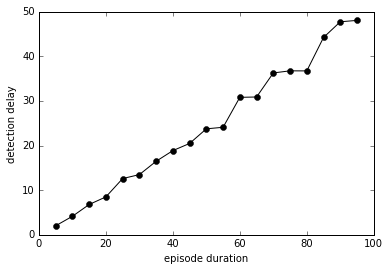

In [16]:
delays = [average_delay(d) for d in ds]
plt.plot(ds, delays, 'k-o')
plt.xlabel('episode duration'); plt.ylabel('detection delay')
plt.savefig('syscalls-detection-delay.pdf')

As can be seen from the plot, the detection delay grows linearly with shell code duration, with factor 0.5, as expected. In other words, by linearly increasing the amount of work we are able to detect patterns with delay which is only half of the pattern duration.